# Task 05 - Non-parametric probability density estimation - Parzen window
## Pattern Recognition and Machine Learning

In [49]:
%load_ext autoreload
%autoreload 2
# uncomment following for interactive matplotlib
# %matplotlib notebook

from parzen import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.optimize as opt
import copy
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
p = my_parzen(np.array([1, 2, 3]), np.array([-1, 0, 2, 1.5, 0]), 1.0)
print(p)

[0.22639369 0.17268428 0.07609717]


## Load data

In [51]:
data = np.load("data_33rpz_parzen.npz", allow_pickle=True)
tst = data["tst"].item()
trn = data["trn"].item()

## Tasks, part 1
#### measurements

In [52]:
x = compute_measurement_lr_cont(trn['images'])

# splitting the trainning data into classes
idxs = np.squeeze(trn['labels'])
xA = x[idxs == 0]
xC = x[idxs == 1]

#### computing the histograms of training data

In [53]:
len(xA)

1179

In [54]:
xA

array([  357., -1113.,   703., ...,  -494.,  1576.,   985.])

In [55]:
hist_A, bins_A = np.histogram(xA, 20, density=True)

hist_C, bins_C = np.histogram(xC, 20, density=True)

#### estimating conditional probability using Parzen window

In [56]:
x_range = np.arange(np.min(xA), np.max(xA), 100)
h = [100., 500., 1000., 2000.]

y = np.zeros([len(h), x_range.size], np.float64)
for i in range(len(h)):
    y[i,:] = my_parzen(x_range, xA, h[i])

#### visualisation

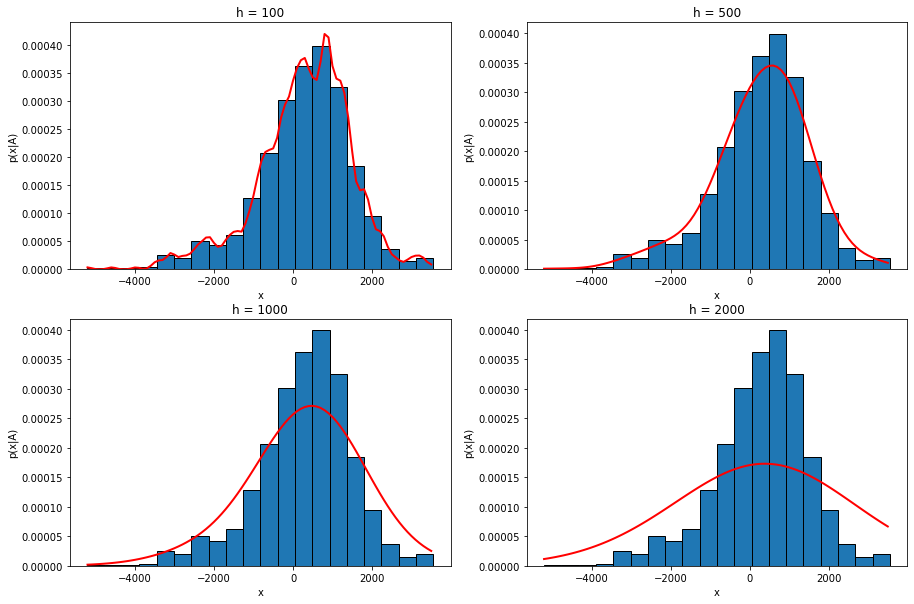

In [57]:
def plot_parzen(x, y, hist, bins, h=500., cls='A'):
    centers = (bins[:-1] + bins[1:]) / 2
    width = bins[:-1] - bins[1:]
    plt.bar(centers, hist, width=width, edgecolor='k')
    plt.plot(x.T, y.T, 'r', linewidth=2)
    plt.title('h = {:.0f}'.format(h))
    plt.xlabel('x')
    plt.ylabel('p(x|{})'.format(cls))

# plots of the estimates
plt.figure(figsize=(15,10))

for idx in range(4):
    cur_h = h[idx]
    plt.subplot(2,2,idx+1)
    plot_parzen(x_range, y[idx:(idx+1),:], hist_A, bins_A, h=cur_h)
    
plt.savefig('parzen_estimates.png')

#### interactive visualisation
This is an optional feature. You do not need this for the assignment fulfil.
In the case that you are intereted, install **ipywidgets** and you can play with **the slider**.

In [58]:
try:
    from ipywidgets import interact, interactive, fixed
    
    @interact(h=(10.,2000.,10.))
    def plot_parzen_interactive(h=500.):
        plt.figure(figsize=(15,10))
        x_range = np.arange(np.min(xA), np.max(xA), 100)
        y = my_parzen(x_range, xA, h)
        plot_parzen(x_range, y, hist_A, bins_A, h=h)
        plt.ylim([0, 4.5e-4])

except ImportError:
    print('Optional feature.')


interactive(children=(FloatSlider(value=500.0, description='h', max=2000.0, min=10.0, step=10.0), Output()), _…

## Tasks, part 2
#### 10-fold cross-validation init

In [59]:
# h_range = np.arange(100,1000+1e-8,50)
h_range = np.linspace(100,1000,19)
num_folds = 10

#### class A cross-validation

In [60]:
np.random.seed(42)   # to get the same example outputs

num_data = xA.size
itrn, itst = crossval(num_data, num_folds)

Lh = [compute_Lh(itrn, itst, xA, h) for h in h_range]

In [61]:
Lh

[-1002.5710308871528,
 -999.7461727801974,
 -998.7852273253618,
 -998.4012439822421,
 -998.2866339674608,
 -998.3311487132034,
 -998.4876797930086,
 -998.737448073847,
 -999.0741443712093,
 -999.4958179540383,
 -1000.0016077804152,
 -1000.5908283689769,
 -1001.2627291481161,
 -1002.0162620173342,
 -1002.8498232198341,
 -1003.7610963122073,
 -1004.7470460207918,
 -1005.8040256301117,
 -1006.9279352667527]

#### optimal value of parameter h

In [62]:
h_bestA, Lh_bestA, _, _ = opt.fminbound(lambda x: -compute_Lh(itrn, itst, xA, x), 100, 1000, full_output=True)
Lh_bestA = -Lh_bestA
h_bestA, Lh_bestA

(307.9168718230698, -998.2847803499911)

#### plots of optimal h

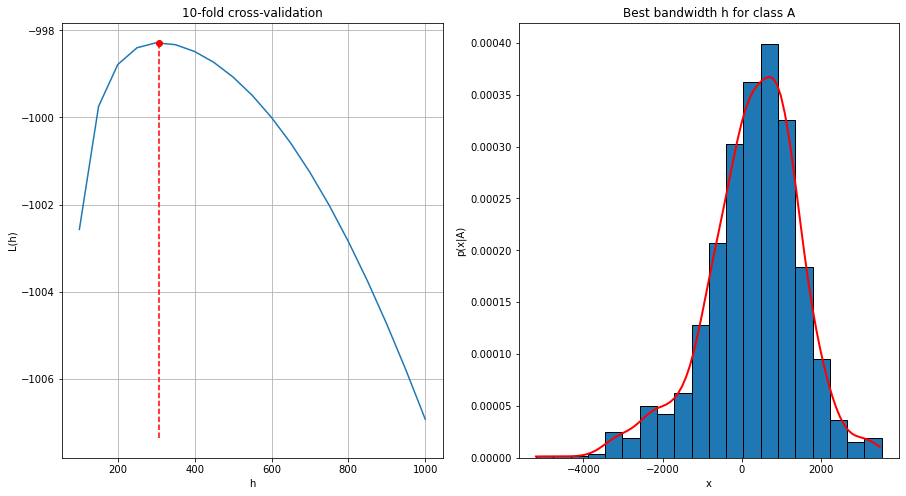

In [63]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(h_range, Lh)
plt.plot(h_bestA, Lh_bestA, 'or')
bottom, _ = plt.ylim()
plt.plot([h_bestA, h_bestA], [bottom, Lh_bestA], '--r');
plt.title('10-fold cross-validation')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.grid('on')

y = my_parzen(x_range, xA, h_bestA)
plt.subplot(1,2,2)
plot_parzen(x_range, y, hist_A, bins_A, h=h_bestA)
plt.title('Best bandwidth h for class A')
plt.savefig('optimal_h_classA.png')

#### class C cross-validation

In [64]:
x_range = np.arange(np.min(xC),np.max(xC),100)

np.random.seed(42)   # to get the same example outputs

num_data = xC.size
itrn, itst = crossval(num_data, num_folds)

Lh = np.zeros([h_range.size])
for h_iter in range(h_range.size):
    Lh[h_iter] = compute_Lh(itrn, itst, xC, float(h_range[h_iter]))

#### optimal value of parameter h

In [65]:
h_bestC = float(opt.fminbound(lambda h: -compute_Lh(itrn, itst, xC, float(h)), h_range[0], h_range[-1]))
Lh_bestC = compute_Lh(itrn, itst, xC, h_bestC)

#### plots of optimal h

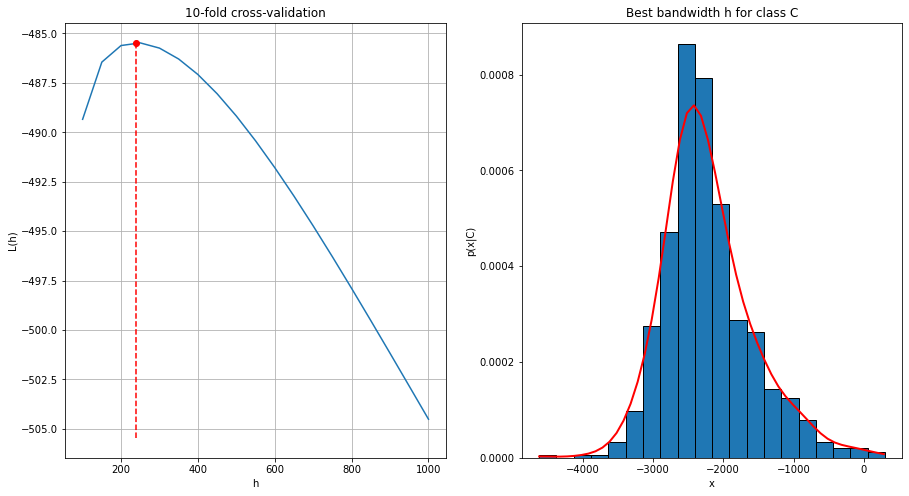

In [66]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(h_range, Lh)
plt.plot(h_bestC, Lh_bestC, 'or')
bottom, _ = plt.ylim()
plt.plot([h_bestC, h_bestC], [bottom, Lh_bestC], '--r');
plt.title('10-fold cross-validation')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.grid('on')

y = my_parzen(x_range, xC, h_bestC)
plt.subplot(1,2,2)
plot_parzen(x_range, y, hist_C, bins_C, h=h_bestC, cls='C')
plt.title('Best bandwidth h for class C')
plt.savefig('optimal_h_classC.png')

## Bayesian classifier

In [67]:
x_test = compute_measurement_lr_cont(tst['images'])

# computing a priori probabilities
pA = len(xA) / len(x)
pC = len(xC) / len(x)
labels = classify_bayes_parzen(x_test, xA, xC, pA, pC, h_bestA, h_bestC)

#### visualisation

In [70]:
labels == idxs

/tmp/ipykernel_4387/338079104.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  labels == idxs


False

0.075


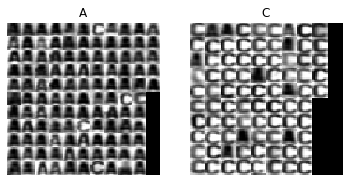

In [17]:
show_classification(tst['images'], labels, 'AC')
plt.savefig('parzen_classif.png')

# classification error
bayes_error = 
print(bayes_error)

In [18]:
print(h_bestA, h_bestC)

307.91681045078644 238.67959502171266
